In [1]:
import sqlite3
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from StrategyMatrix import *
from AgentStrategyMatrix import *

In [2]:
savepath = "E:/HumanA/Analysis/Descriptives/"

In [3]:
def getNodeCount():
    sql_instruction = """SELECT trials.participantId, trials.sessionNr, trials.validParticipant,trials.validSession, 
                        COUNT(dataPoints_analysis.node)
                        FROM trials
                        LEFT JOIN dataPoints_analysis ON trials.id = dataPoints_analysis.trialId
                        WHERE validSession = 'VALID' AND validParticipant = 'VALID'
                        GROUP BY trials.participantId, trials.sessionNr
                        ORDER BY trials.participantId, trials.sessionNr, dataPoints_analysis.timeStampDataPointStart;"""

    cr.execute(sql_instruction)
    df = pd.DataFrame(cr.fetchall())
    df = df.rename(columns = {0 : 'ParticipantID', 1: 'SessionNr', 2: 'validParticipant', 3:'validSession', 
                              4: 'NodeCount'})
    return df

In [4]:
def getDecisionCount():
    sql_instruction = """SELECT trials.participantId , trials.sessionNr, trials.validParticipant, trials.validSession, 
            participant_decision.decision, COUNT(participant_decision.decision)
            FROM trials
            LEFT JOIN dataPoints_analysis ON trials.id = dataPoints_analysis.trialId
            LEFT JOIN participant_decision ON dataPoints_analysis.datapointId = participant_decision.datapointId
            WHERE trials.validParticipant = 'VALID' AND trials.validSession = 'VALID'
            GROUP BY trials.participantId, trials.sessionNr, participant_decision.decision
            ORDER BY trials.participantId, trials.sessionNr;"""

    cr.execute(sql_instruction)
    df = pd.DataFrame(cr.fetchall())
    df = df.rename(columns = {0 : 'ParticipantID', 1: 'SessionNr', 2: 'validParticipant', 3:'validSession', 
                              4: 'Decision', 5: 'DecisionCount'})
    return df

In [5]:
def getSessionTimes():
    sql_instruction = """SELECT participantId , sessionNr, validParticipant, validSession, ROUND(SUM(timeTrialMeasurementStopped - timeTrialMeasurementStarted)/60) AS Duration
                        FROM trials
                        WHERE trials.validParticipant = 'VALID' AND trials.validSession = 'VALID'
                        GROUP BY participantId, sessionNr
                        ORDER BY participantId, sessionNr;"""

    cr.execute(sql_instruction)
    df = pd.DataFrame(cr.fetchall())
    df = df.rename(columns = {0 : 'ParticipantID', 1: 'SessionNr', 2: 'validParticipant', 3:'validSession', 
                              4: 'Duration'})
    return df

In [6]:
def getDataFromDB():
    sql_instruction = """SELECT trials.participantId, trials.sessionNr, trials.id, trials.validParticipant, dataPoints_analysis.DatapointId, 
                            dataPoints_analysis.node
                        FROM trials
                        LEFT JOIN dataPoints_analysis ON trials.id = dataPoints_analysis.trialId
                        WHERE validSession = 'VALID' AND validParticipant = 'VALID'
                        ORDER BY trials.participantId, trials.sessionNr, dataPoints_analysis.timeStampDataPointStart;"""

    cr.execute(sql_instruction)
    df = pd.DataFrame(cr.fetchall())
    df = df.rename(columns = {0 : 'ParticipantID', 1: 'SessionNr', 2: 'TrialId', 3: 'validParticipant', 4:'DatapointID', 
                              5: 'Node'})
    return df

In [7]:
def getIncludedParticipants():
    sql_instruction = """SELECT DISTINCT participantId 
                            FROM trials 
                            WHERE validParticipant = 'VALID' 
                                AND validSession = 'VALID';
                      """
    cr.execute(sql_instruction)
    participants = tuple(did[0] for did in cr.fetchall())
    return participants

In [8]:
def getExcludedParticipants():
    sql_instruction = """SELECT DISTINCT participantId 
                            FROM trials 
                            WHERE NOT validParticipant = 'VALID' AND NOT validParticipant = 'INVALID'
                                ;
                      """
    cr.execute(sql_instruction)
    participants = tuple(did[0] for did in cr.fetchall())
    return participants

In [9]:
db_path = Path('E:/HumanA/Data/Database/HumanA_Exp1.db')
savepath = savepath + "Exp1/"

# check if path exists
if not db_path or not db_path.exists():
    db_path = ':memory:'

# connect to database
connection=sqlite3.connect(db_path)
cr=connection.cursor()

In [10]:
# set color palette for plots
color_palette = ["#84a98c", "#625f63", "#cad2c5", '#f2cc8f', '#b36a5e']

In [11]:
inc_participants = getIncludedParticipants()

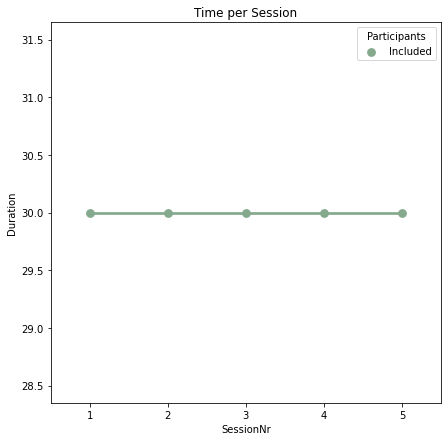

In [12]:
data_times = getSessionTimes()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
#sns.set(palette='muted', style='ticks',)
#color_palette = ["#81b29a", "#e07a5f", "#f2cc8f"]
sns.set_palette(palette=color_palette)
timeplot = sns.pointplot(x='SessionNr', y='Duration', hue='validParticipant', 
                   dodge=True, data=data_times, ax=ax)

ax.set_title(r'Time per Session')
legend_labels,_=ax.get_legend_handles_labels()
ax.legend(legend_labels,['Included','Excluded'],title='Participants')
plt.show()

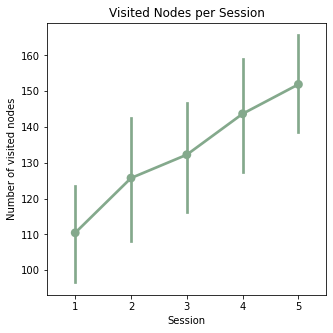

In [13]:
data_nodes = getNodeCount()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
#color_palette = ["#84a98c", "#625f63", "#cad2c5"]
sns.set_palette(palette=color_palette)
ax = sns.pointplot(x='SessionNr', y='NodeCount', dodge=True, data=data_nodes, ax=ax)#ci=68, ax=ax)
ax.set_title('Visited Nodes per Session')
legend_labels,_=ax.get_legend_handles_labels()
ax.set_ylabel('Number of visited nodes')
ax.set_xlabel('Session')
#ax.legend(legend_labels,['Included','Excluded'],title='Participants')
plt.show()

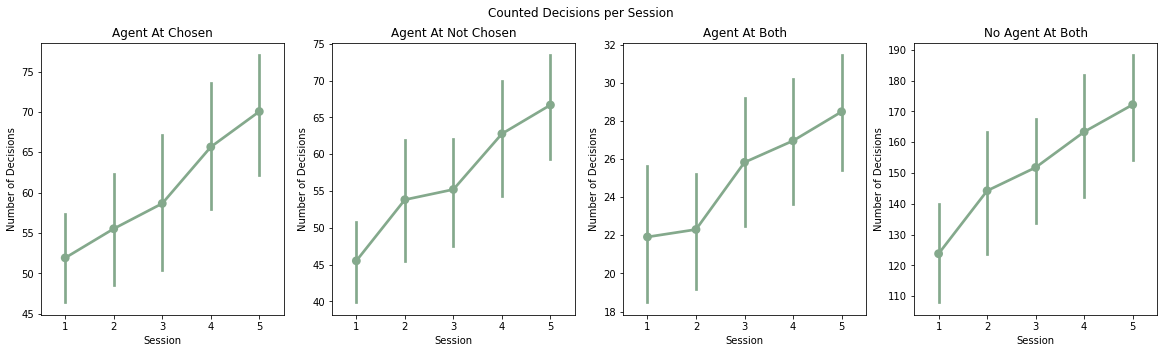

In [14]:
data_decision = getDecisionCount()
data_decision = data_decision[data_decision['Decision'].notnull()]
decisions = ('AvatarAtChosen', 'AvatarAtNotChosen', 'AvatarAtBoth', 'NoAvatarAtBoth')
subtitle_text = ('Agent At Chosen', 'Agent At Not Chosen', 'Agent At Both', 'No Agent At Both')
nrows, ncols = 1,4
#idx = 0
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,5))
fig.suptitle('Counted Decisions per Session')
plt.subplots_adjust(hspace = 0.3)
#color_palette = ["#81b29a", "#e07a5f", "#f2cc8f"]
sns.set_palette(palette=color_palette)

for col in range(4):
    #for col in range(ncols):
        sns.pointplot(x='SessionNr', y='DecisionCount', dodge=True,
                          data=data_decision[data_decision['Decision'] == decisions[col]],
                          ax=axes[col], order=[1, 2, 3, 4, 5])
        #sns.pointplot(x='SessionNr', y='DecisionCount', dodge=True,
        #                  data=data_decision[data_decision['Decision'] == decisions[idx]],
        #                  ax=axes[row][col], order=[1, 2, 3, 4, 5])
        axes[col].set_title(f'{subtitle_text[col]}')
        legend_labels,_=axes[col].get_legend_handles_labels()
        axes[col].set_ylabel('Number of Decisions')
        axes[col].set_xlabel('Session')
        
        
        #idx += 1
plt.show()

Text(0.5, 1.0, 'Data Proportion')

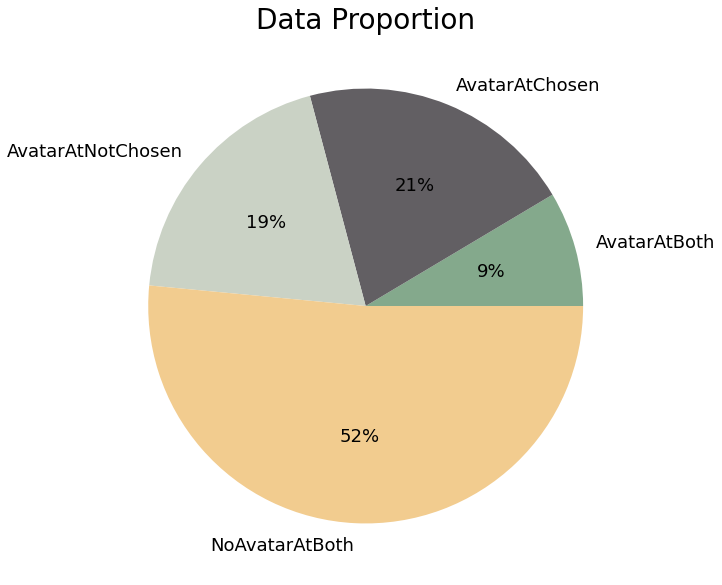

In [15]:
def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'

data_grouped = data_decision.groupby(['Decision'])
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
data_grouped['DecisionCount'].sum().plot(kind='pie', textprops={'fontsize': 18}, autopct = '%1.0f%%', ax = ax)#, autopct=label_function)
ax.set_ylabel('')
ax.set_title('Data Proportion', fontsize = 28)


C:\Users\Kaya\AppData\Local\Temp/ipykernel_10584/129217164.py:11: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  legend = ax.legend(pie[0], labels=label_text, fontsize=14, bbox_to_anchor=(0.9, 0.8))#loc='upper right')#, bbox_to_anchor=(1.2, 0.5))


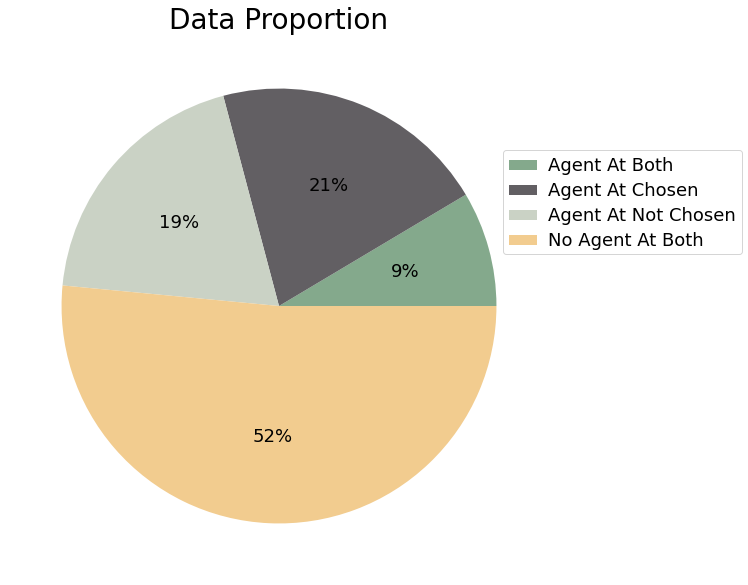

In [16]:

data_grouped = data_decision.groupby(['Decision'])
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
pie = ax.pie(data_grouped['DecisionCount'].sum(), labels=None, autopct='%1.0f%%')
label_text = ('Agent At Both','Agent At Chosen', 'Agent At Not Chosen', 'No Agent At Both')

ax.set_ylabel('')
ax.set_title('Data Proportion', fontsize=28)

# Create a legend with labels from the data
legend_labels = data_grouped['DecisionCount'].sum().index.tolist()
legend = ax.legend(pie[0], labels=label_text, fontsize=14, bbox_to_anchor=(0.9, 0.8))#loc='upper right')#, bbox_to_anchor=(1.2, 0.5))

# Increase the font size of the legend labels
for text in legend.get_texts():
    text.set_fontsize(18)

# Increase the font size of the displayed numbers in the slices
for autotext in pie[2]:
    autotext.set_fontsize(18)

plt.show()

In [17]:
df = pd.DataFrame(columns=['ParticipantId', 'Session', 'StrategyCount', 'StrategyPerc' ,'Strategy', 'Conservative', 'Explorative', 'Total', 'Participant_Cat'])

In [18]:
all_StrategyMatrices = []
for idx in range(len(inc_participants)):
    strategyMatrix = StrategyMatrix(inc_participants[idx], cr)
    sessions = strategyMatrix.sessions
    for session in sessions:
        cons_strat, expl_strat, tot_strat = StrategyMatrix.getStrategyCounts(strategyMatrix.matrix_total[session-1])
        if tot_strat != 0:
            perc_cons = round((cons_strat/tot_strat), 2)
            perc_expl = round((expl_strat/tot_strat),2)
        else:
            perc_cons = 0 
            perc_expl = 0

        df = df.append({'ParticipantId' : inc_participants[idx], 'Session' : session, 'StrategyCount' : cons_strat,
                        'StrategyPerc' : perc_cons, 'Strategy': 'Conservative', 'Total' : tot_strat, 
                        'Participant_Cat' : 'Included'}, ignore_index = True)
        df = df.append({'ParticipantId' : inc_participants[idx], 'Session' : session, 'StrategyCount' : expl_strat, 
                        'StrategyPerc' : perc_expl,'Strategy': 'Explorative', 'Total' : tot_strat, 
                        'Participant_Cat' : 'Included'}, ignore_index = True)
    all_StrategyMatrices.append(strategyMatrix)

In [19]:
df

,ParticipantId,Session,StrategyCount,StrategyPerc,Strategy,Conservative,Explorative,Total,Participant_Cat
0,1754,1,37.0,0.25,Conservative,NaN,NaN,148.0,Included
1,1754,1,111.0,0.75,Explorative,NaN,NaN,148.0,Included
2,1754,2,77.0,0.37,Conservative,NaN,NaN,209.0,Included
3,1754,2,132.0,0.63,Explorative,NaN,NaN,209.0,Included
4,1754,3,132.0,0.44,Conservative,NaN,NaN,302.0,Included
...,...,...,...,...,...,...,...,...,...
225,9586,3,77.0,0.51,Explorative,NaN,NaN,151.0,Included
226,9586,4,64.0,0.46,Conservative,NaN,NaN,138.0,Included
227,9586,4,74.0,0.54,Explorative,NaN,NaN,138.0,Included
228,9586,5,69.0,0.49,Conservative,NaN,NaN,142.0,Included


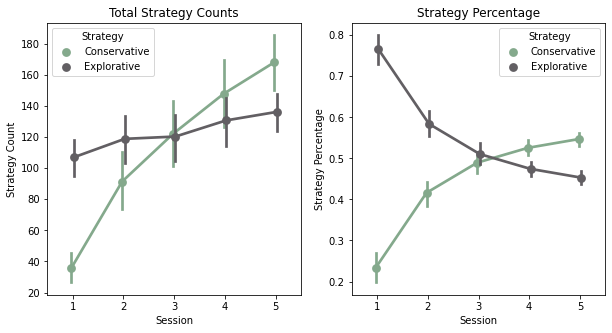

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
#fig.suptitle('Total Strategy Counts')
#color_palette = ["#81b29a", "#e07a5f", "#f2cc8f"]
#sns.set_palette(palette=color_palette)
sns.pointplot(x='Session', y='StrategyCount', dodge=True, hue='Strategy',
              data=df[df['Participant_Cat'] == 'Included'],ax=axes[0]).set(ylabel = 'Strategy Count')
sns.pointplot(x='Session', y='StrategyPerc', dodge=True, hue='Strategy',
              data=df[df['Participant_Cat'] == 'Included'],ax=axes[1]).set(ylabel = 'Strategy Percentage')
axes[0].set_title('Total Strategy Counts')
axes[1].set_title('Strategy Percentage')

plt.show()

In [21]:
df_Ratio = pd.DataFrame()
for strategyMatrix in all_StrategyMatrices:
#for idx in range(len(inc_participants)):
    #strategyMatrix = StrategyMatrix(inc_participants[idx], cr)
    participant = strategyMatrix.participantId
    sessions = strategyMatrix.sessions  
    for session in sessions:
        cons_strat, expl_strat, tot_strat = StrategyMatrix.getStrategyCounts(strategyMatrix.matrix_total[session-1])
        if tot_strat != 0:
            perc_cons = round((cons_strat/tot_strat), 2)
            perc_expl = round((expl_strat/tot_strat),2)
        else:
            perc_cons = 0 
            perc_expl = 0

        df_Ratio = df_Ratio.append({'ParticipantId' : participant, 'Session' : session, 'StrategyCons' : cons_strat,
                        'StrategyExpl' : expl_strat, 'StrategyPercCons' : perc_cons, 'StrategyPercExpl' : perc_expl, 
                        'Total' : tot_strat, 'Participant_Cat' : 'Included'}, ignore_index = True)
        #df = df.append({'ParticipantId' : inc_participants[idx], 'Session' : session, 'StrategyExpl' : expl_strat, 
        #                'StrategyPercExpl' : perc_expl,'Strategy': 'Explorative', 'Total' : tot_strat, 
        #                'Participant_Cat' : 'Included'}, ignore_index = True)

In [22]:
df_Ratio[df_Ratio['Session'] == 1]

,ParticipantId,Session,StrategyCons,StrategyExpl,StrategyPercCons,StrategyPercExpl,Total,Participant_Cat
0,1754.0,1.0,37.0,111.0,0.25,0.75,148.0,Included
5,2258.0,1.0,55.0,144.0,0.28,0.72,199.0,Included
10,2693.0,1.0,46.0,96.0,0.32,0.68,142.0,Included
15,3310.0,1.0,9.0,48.0,0.16,0.84,57.0,Included
20,4176.0,1.0,12.0,74.0,0.14,0.86,86.0,Included
25,4796.0,1.0,79.0,130.0,0.38,0.62,209.0,Included
30,4917.0,1.0,30.0,108.0,0.22,0.78,138.0,Included
35,5238.0,1.0,44.0,147.0,0.23,0.77,191.0,Included
40,5741.0,1.0,47.0,78.0,0.38,0.62,125.0,Included
45,6642.0,1.0,23.0,113.0,0.17,0.83,136.0,Included


In [23]:
df_Ratio['Ratio'] = df_Ratio['StrategyExpl'] / df_Ratio['StrategyCons']

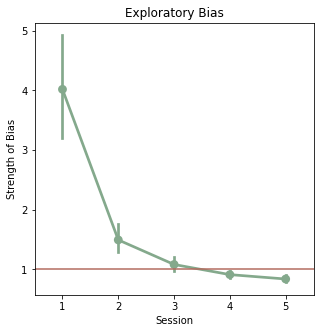

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

sns.pointplot(x='Session', y='Ratio', dodge=True,
              data=df_Ratio,ax=axes, order=[1, 2, 3, 4, 5]).set(ylabel = 'Strength of Bias')
#sns.pointplot(x='Session', y='StrategyPerc', dodge=True, hue='Strategy',
#              data=df[df['Participant_Cat'] == 'Included'],ax=axes[1]).set(ylabel = 'Strategy Percentage')
axes.set_title('Exploratory Bias')
axes.axhline(1.0, color = '#b36a5e')
#axes[1].set_title('Strength of Bias')

plt.show()

In [25]:
df_agent = pd.DataFrame(columns=['ParticipantId', 'Session', 'StrategyCount', 'StrategyPerc' ,'Strategy', 
                                 'Decision','Conservative', 'Explorative', 'Total', 'Participant_Cat'])
decisions = ('AgentAtChosen', 'AgentAtNotChosen', 'AgentAtBoth', 'NoAgentAtBoth')

In [26]:
all_agentStrategyMatrices = []
for idx in range(len(inc_participants)):
    print('Participant: ' + str(inc_participants[idx]))
    agentStrategyMatrix = AgentStrategyMatrix(inc_participants[idx], cr)
    #strategyMatrix.createMatrix()
    sessions = agentStrategyMatrix.getSessions()
    for session in sessions:
        idx = 0
        for matrix in agentStrategyMatrix.matrix_total:
            cons_strat, expl_strat, tot_strat = StrategyMatrix.getStrategyCounts(matrix[session-1])
            if tot_strat != 0:
                perc_cons = round((cons_strat/tot_strat), 2)
                perc_expl = round((expl_strat/tot_strat),2)
            else:
                perc_cons = 0 
                perc_expl = 0

            df_agent = df_agent.append({'ParticipantId' : inc_participants[idx], 'Session' : session, 'StrategyCount' : cons_strat,
                            'StrategyPerc' : perc_cons, 'Strategy': 'Conservative', 'Decision' : decisions[idx], 
                            'Total' : tot_strat,'Participant_Cat' : 'Included'}, ignore_index = True)
            df_agent = df_agent.append({'ParticipantId' : inc_participants[idx], 'Session' : session, 'StrategyCount' : expl_strat, 
                            'StrategyPerc' : perc_expl,'Strategy': 'Explorative', 'Decision' : decisions[idx],
                            'Total' : tot_strat, 'Participant_Cat' : 'Included'}, ignore_index = True)
            idx += 1
    all_agentStrategyMatrices.append(agentStrategyMatrix)

Participant: 1754
Participant: 2258
Participant: 2693
Participant: 3310
Participant: 4176
Participant: 4796
Participant: 4917
Participant: 5238
Participant: 5741
Participant: 6642
Participant: 7093
Participant: 7412
Participant: 7842
Participant: 8007
Participant: 8469
Participant: 8673
Participant: 8695
Participant: 9472
Participant: 9502
Participant: 9601
Participant: 365
Participant: 4597
Participant: 9586


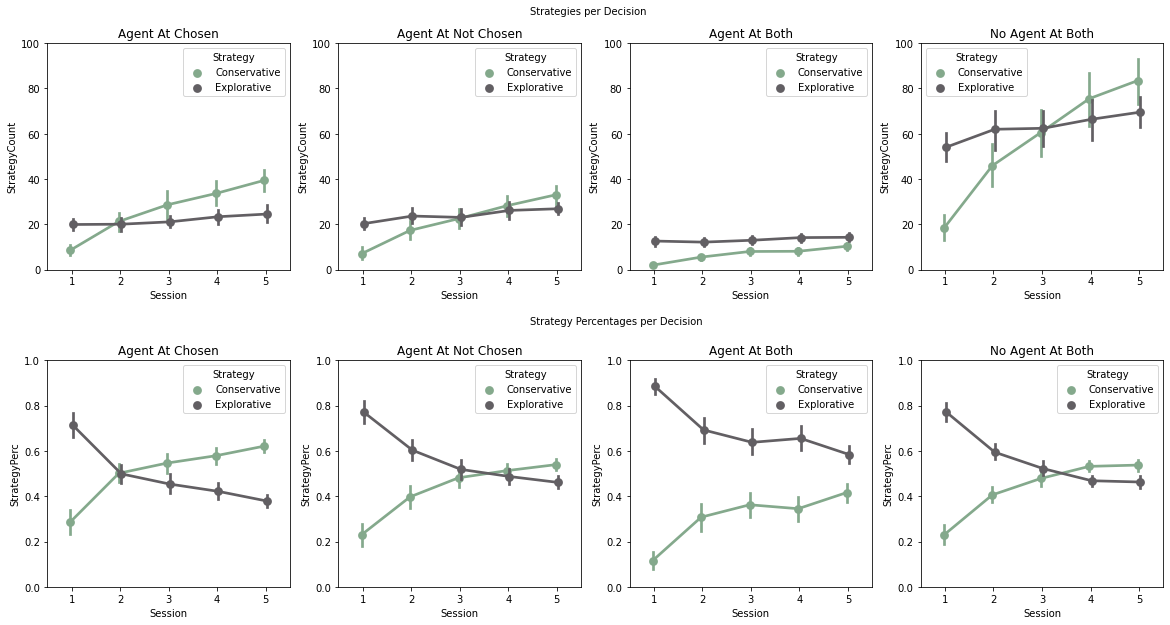

In [27]:
df_inc = df_agent[df_agent['Participant_Cat'] == 'Included']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
plt.subplots_adjust(hspace = 0.4)
#fig.suptitle('Strategies per Decision')
fig.text(x=0.46, y=0.92, s="Strategies per Decision")
fig.text(x=0.46, y=0.49, s="Strategy Percentages per Decision")
subtitle_text = ('Agent At Chosen', 'Agent At Not Chosen', 'Agent At Both', 'No Agent At Both')

sns.set_palette(palette=color_palette)
#fig.suptitle('Included')
for row in range(2):
    for col in range(4):
        if row == 0:
            sns.pointplot(x='Session', y='StrategyCount', dodge=True, hue='Strategy',
                  data=df_inc[df_inc['Decision'] == decisions[col]],ax=axes[row][col]).set_title(subtitle_text[col])
            axes[row][col].set_ylim(0, 100)
        else:
            sns.pointplot(x='Session', y='StrategyPerc', dodge=True, hue='Strategy',
                  data=df_inc[df_inc['Decision'] == decisions[col]],ax=axes[row][col]).set_title(subtitle_text[col])
            axes[row][col].set_ylim(0, 1)


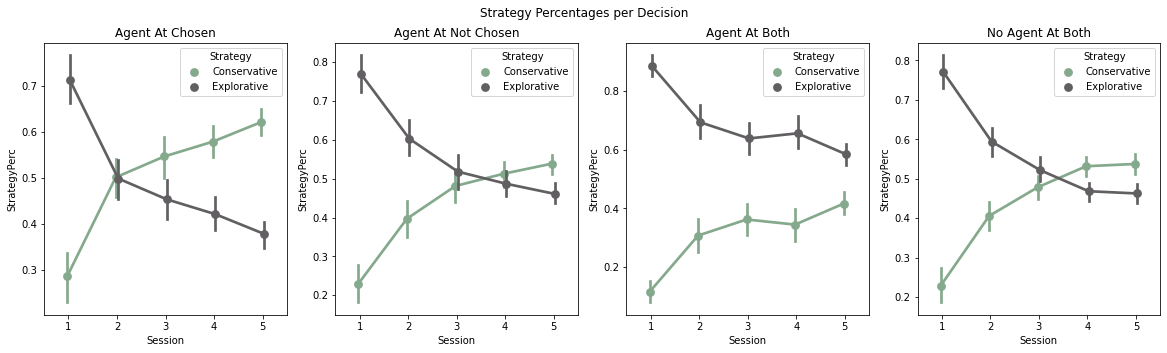

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))    
plt.subplots_adjust(hspace = 0.4)
fig.suptitle('Strategy Percentages per Decision')
sns.set_palette(palette=color_palette)
subtitle_text = ('Agent At Chosen', 'Agent At Not Chosen', 'Agent At Both', 'No Agent At Both')

for col in range(4):
    sns.pointplot(x='Session', y='StrategyPerc', dodge=True, hue='Strategy',
          data=df_inc[df_inc['Decision'] == decisions[col]],ax=axes[col]).set_title(subtitle_text[col])

In [29]:
df_Ratio_Dec = pd.DataFrame()

#for idx in range(len(inc_participants)):
for agentStrategyMatrix in all_agentStrategyMatrices:
    participant = agentStrategyMatrix.participantId
    #print('Participant: ' + str(inc_participants[idx]))
    #agentStrategyMatrix = AgentStrategyMatrix(inc_participants[idx], cr)
    sessions = agentStrategyMatrix.getSessions()
    for session in sessions:
        idx = 0
        for matrix in agentStrategyMatrix.matrix_total:
            cons_strat, expl_strat, tot_strat = StrategyMatrix.getStrategyCounts(matrix[session-1])
            if tot_strat != 0:
                perc_cons = round((cons_strat/tot_strat), 2)
                perc_expl = round((expl_strat/tot_strat),2)
            else:
                perc_cons = 0 
                perc_expl = 0

            df_Ratio_Dec = df_Ratio_Dec.append({'ParticipantId' : participant, 'Session' : session, 'StrategyCons' : cons_strat,
                             'StrategyExpl' : expl_strat,'StrategyPerc_Cons' : perc_cons,'StrategyPerc_Expl' : perc_expl, 'Decision' : decisions[idx], 
                            'Total' : tot_strat,'Participant_Cat' : 'Included'}, ignore_index = True)
            idx += 1


In [30]:
df_Ratio_Dec['Ratio'] = df_Ratio_Dec['StrategyExpl'] / df_Ratio_Dec['StrategyCons']

In [31]:
df_Ratio_Dec['Ratio'] = df_Ratio_Dec['Ratio'].replace(np.inf, 0)

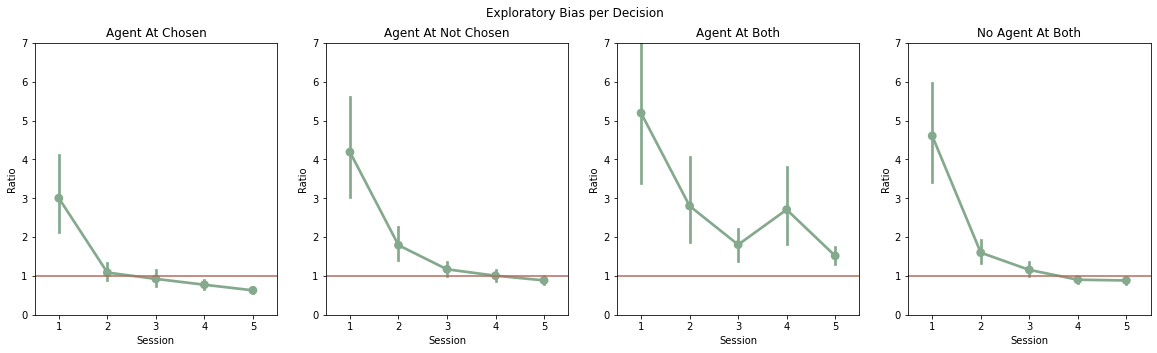

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))    
plt.subplots_adjust(hspace = 0.4)
fig.suptitle('Exploratory Bias per Decision')
sns.set_palette(palette=color_palette)
subtitle_text = ('Agent At Chosen', 'Agent At Not Chosen', 'Agent At Both', 'No Agent At Both')

for col in range(4):
    sns.pointplot(x='Session', y='Ratio', dodge=True,
          data=df_Ratio_Dec[df_Ratio_Dec['Decision'] == decisions[col]],ax=axes[col], order=[1, 2, 3, 4, 5]).set_title(subtitle_text[col])
    axes[col].axhline(1.0, color = '#b36a5e')
    axes[col].set_ylim(0, 7)

In [33]:
def getAvatarPositions():
    sql_instruction = f"""SELECT node FROM avatars_reduced WHERE graph_element_type = 'Node'"""
    cr.execute(sql_instruction)
    avatarNodes = [did[0] for did in cr.fetchall()]

    sql_instruction = f"""SELECT edge_start,edge_end FROM avatars_reduced WHERE graph_element_type = 'Edge'"""
    cr.execute(sql_instruction)
    avatarEdges = [list(did) for did in cr.fetchall()]

    return avatarNodes,avatarEdges

In [34]:
avatarNodes, avatarEdges = getAvatarPositions()

In [35]:
def getAvatarNode(x_coor, z_coor):
    sql_instruction = f"""SELECT DISTINCT nodeNr
        FROM graph_coordinates 
        WHERE ABS(({x_coor} - graph_coordinates.nodeCentroid_x)*({x_coor} - graph_coordinates.nodeCentroid_x) + 
                ({z_coor} - graph_coordinates.nodeCentroid_z)*({z_coor} - graph_coordinates.nodeCentroid_z)) = (
                SELECT MIN(ABS(({x_coor} - graph_coordinates.nodeCentroid_x)*({x_coor} - graph_coordinates.nodeCentroid_x) + 
                    ({z_coor} - graph_coordinates.nodeCentroid_z)*({z_coor} - graph_coordinates.nodeCentroid_z))) 
                FROM graph_coordinates)"""
    cr.execute(sql_instruction)
    avatarNode = [did[0] for did in cr.fetchall()]
    return avatarNode[0]


In [36]:
def getAvatarCoor(avatar):
    sql_instruction = f"""SELECT coor_converted_x, coor_converted_z FROM avatars_reduced WHERE avatarId = {avatar}"""
    cr.execute(sql_instruction)
    #avatarCoors = cr.fetchall()
    avatarCoors = [did for did in cr.fetchone()]
    return avatarCoors

In [37]:
avatarNodes = []
for i in range(1,57):
    avatarCoors = getAvatarCoor(i)
    avatarNode = getAvatarNode(avatarCoors[0], avatarCoors[1])
    avatarNodes.append(avatarNode)
print(avatarNodes)

[146, 52, 143, 37, 70, 142, 156, 25, 48, 15, 105, 32, 120, 155, 54, 105, 26, 72, 80, 119, 90, 92, 89, 152, 53, 115, 11, 147, 91, 147, 40, 47, 125, 152, 157, 132, 118, 124, 116, 114, 111, 104, 103, 98, 78, 76, 67, 74, 65, 57, 43, 30, 9, 16, 150, 32]


In [62]:
len(avatarNodes)

56

In [38]:
df_Visits_Total = pd.DataFrame()
#for idx in range(len(inc_participants)):
for agentStrategyMatrix in all_agentStrategyMatrices:
    participant = agentStrategyMatrix.participantId
    print('Participant: ' + str(participant))
    sessions = agentStrategyMatrix.getSessions()
    for session in sessions:
        node_nr = 0
        #print('Session: ' + str(session))
        #print(agentStrategyMatrix.total_visits_over_sessions[session-1])
        for visit in agentStrategyMatrix.total_visits_over_sessions[session-1]:
            df_Visits_Total = df_Visits_Total.append({'ParticipantId' : participant, 'Session' : session, 'Node' : node_nr, 
                                          'Visits': visit}, ignore_index = True)
            node_nr += 1
df_Visits_Total['Agent'] = df_Visits_Total['Node'].isin(avatarNodes)
#df_Visits_Total['Agent'] = df_Visits_Total['Node'].isin(avatarNodes) | df_Visits_Total['Node'].apply(lambda x: any(x in sublist for sublist in avatarEdges))

Participant: 1754
Participant: 2258
Participant: 2693
Participant: 3310
Participant: 4176
Participant: 4796
Participant: 4917
Participant: 5238
Participant: 5741
Participant: 6642
Participant: 7093
Participant: 7412
Participant: 7842
Participant: 8007
Participant: 8469
Participant: 8673
Participant: 8695
Participant: 9472
Participant: 9502
Participant: 9601
Participant: 365
Participant: 4597
Participant: 9586


In [39]:
df_Visits_Total

,ParticipantId,Session,Node,Visits,Agent
0,1754.0,1.0,0.0,2.0,False
1,1754.0,1.0,1.0,0.0,False
2,1754.0,1.0,2.0,1.0,False
3,1754.0,1.0,3.0,2.0,False
4,1754.0,1.0,4.0,1.0,False
...,...,...,...,...,...
18280,9586.0,5.0,154.0,2.0,False
18281,9586.0,5.0,155.0,4.0,True
18282,9586.0,5.0,156.0,4.0,True
18283,9586.0,5.0,157.0,3.0,True


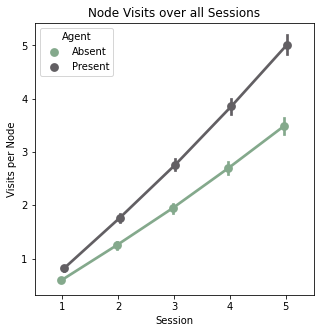

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax = sns.pointplot(x='Session', y='Visits', dodge=True, data=df_Visits_Total, hue = 'Agent', ax=ax, order=[1, 2, 3, 4, 5])
ax.set_title('Node Visits over all Sessions')
legend_labels,_=ax.get_legend_handles_labels()
ax.set_ylabel('Visits per Node')
ax.set_xlabel('Session')
ax.legend(legend_labels, ['Absent','Present'], title='Agent') 
#ax.legend(legend_labels,['Included','Excluded'],title='Participants')
plt.show()

In [41]:
df_Visits = pd.DataFrame()
#for idx in range(len(inc_participants)):
for agentStrategyMatrix in all_agentStrategyMatrices:
    participant = agentStrategyMatrix.participantId
    print('Participant: ' + str(participant))
    sessions = agentStrategyMatrix.getSessions()
    for session in sessions:
        node_nr = 0
        for visit in agentStrategyMatrix.visits_over_sessions[session-1]:
            df_Visits = df_Visits.append({'ParticipantId' : participant, 'Session' : session, 'Node' : node_nr, 
                                          'Visits': visit}, ignore_index = True)
            node_nr += 1
df_Visits['Agent'] = df_Visits['Node'].isin(avatarNodes)
#df_Visits['Agent'] = df_Visits['Node'].isin(avatarNodes) | df_Visits['Node'].apply(lambda x: any(x in sublist for sublist in avatarEdges))

Participant: 1754
Participant: 2258
Participant: 2693
Participant: 3310
Participant: 4176
Participant: 4796
Participant: 4917
Participant: 5238
Participant: 5741
Participant: 6642
Participant: 7093
Participant: 7412
Participant: 7842
Participant: 8007
Participant: 8469
Participant: 8673
Participant: 8695
Participant: 9472
Participant: 9502
Participant: 9601
Participant: 365
Participant: 4597
Participant: 9586


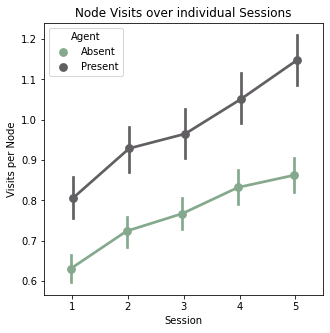

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax = sns.pointplot(x='Session', y='Visits', dodge=True, data=df_Visits, hue = 'Agent', ax=ax,order=[1, 2, 3, 4, 5] )
ax.set_title('Node Visits over individual Sessions')
legend_labels,_=ax.get_legend_handles_labels()
ax.set_ylabel('Visits per Node')
ax.set_xlabel('Session')
ax.legend(legend_labels, ['Absent','Present'], title='Agent') 
#ax.legend(legend_labels,['Included','Excluded'],title='Participants')
plt.show()

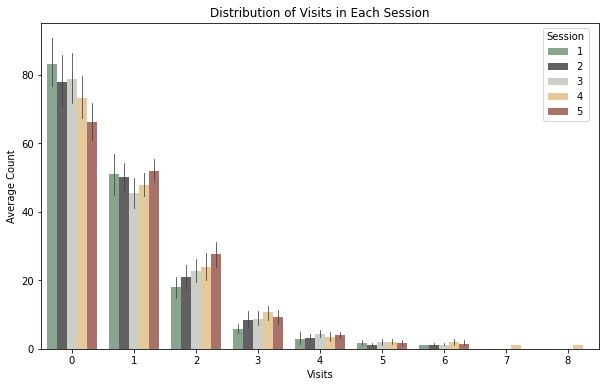

In [43]:
# Calculate the average count of each 'Visits' entry for each session
average_counts = df_Visits.groupby(['ParticipantId','Session', 'Visits']).size().reset_index(name='Average_Count')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Visits', y='Average_Count', hue='Session', data=average_counts, ax=ax, palette=color_palette, errwidth=0.8, 
            order=[0, 1, 2, 3, 4, 5, 6, 7, 8])

ax.set_title('Distribution of Visits in Each Session')
ax.set_xlabel('Visits')
ax.set_ylabel('Average Count')
legend_labels,_=ax.get_legend_handles_labels()
ax.legend(title='Session', bbox_to_anchor=(0.89, 1), loc='upper left')
ax.legend(legend_labels, [1, 2, 3, 4, 5], title='Session', bbox_to_anchor=(0.89, 1), loc='upper left')
plt.show()

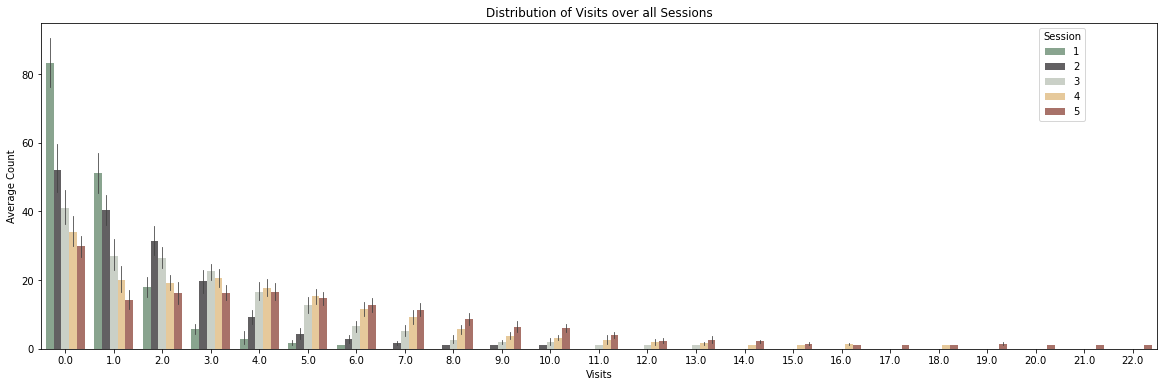

In [44]:
# Calculate the average count of each 'Visits' entry for each session
average_counts = df_Visits_Total.groupby(['ParticipantId','Session', 'Visits']).size().reset_index(name='Average_Count')

# Plotting
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(x='Visits', y='Average_Count', hue='Session', data=average_counts, ax=ax, palette=color_palette, errwidth=0.8,) 
            #order=[0, 1, 2, 3, 4, 5, 6, 7, 8])

ax.set_title('Distribution of Visits over all Sessions')
ax.set_xlabel('Visits')
ax.set_ylabel('Average Count')
legend_labels,_=ax.get_legend_handles_labels()
ax.legend(title='Session', bbox_to_anchor=(0.89, 1), loc='upper left')
ax.legend(legend_labels, [1, 2, 3, 4, 5], title='Session', bbox_to_anchor=(0.89, 1), loc='upper left')
plt.show()

In [45]:
df_Visits_Total[df_Visits_Total['Visits'] > 8]

,ParticipantId,Session,Node,Visits,Agent
437,1754.0,3.0,119.0,9.0,True
442,1754.0,3.0,124.0,12.0,True
567,1754.0,4.0,90.0,10.0,True
585,1754.0,4.0,108.0,9.0,False
588,1754.0,4.0,111.0,10.0,True
...,...,...,...,...,...
17442,4597.0,5.0,111.0,9.0,True
17446,4597.0,5.0,115.0,10.0,True
17455,4597.0,5.0,124.0,9.0,True
17458,4597.0,5.0,127.0,11.0,True


In [46]:
average_counts[average_counts['ParticipantId'] == 365]

,ParticipantId,Session,Visits,Average_Count
0,365.0,1.0,0.0,69
1,365.0,1.0,1.0,38
2,365.0,1.0,2.0,26
3,365.0,1.0,3.0,12
4,365.0,1.0,4.0,10
...,...,...,...,...
60,365.0,5.0,15.0,3
61,365.0,5.0,16.0,1
62,365.0,5.0,19.0,1
63,365.0,5.0,20.0,1


In [47]:
mean_count = df_Visits.groupby('Session')['Visits'].nunique().reset_index()
mean_count = mean_count.rename(columns={'Visits': 'Mean_Count'})

In [48]:
mean_count_visits = df_Visits.groupby(['ParticipantId', 'Session', 'Visits']).count()

In [49]:
mean_count

,Session,Mean_Count
0,1.0,7
1,2.0,7
2,3.0,7
3,4.0,9
4,5.0,7


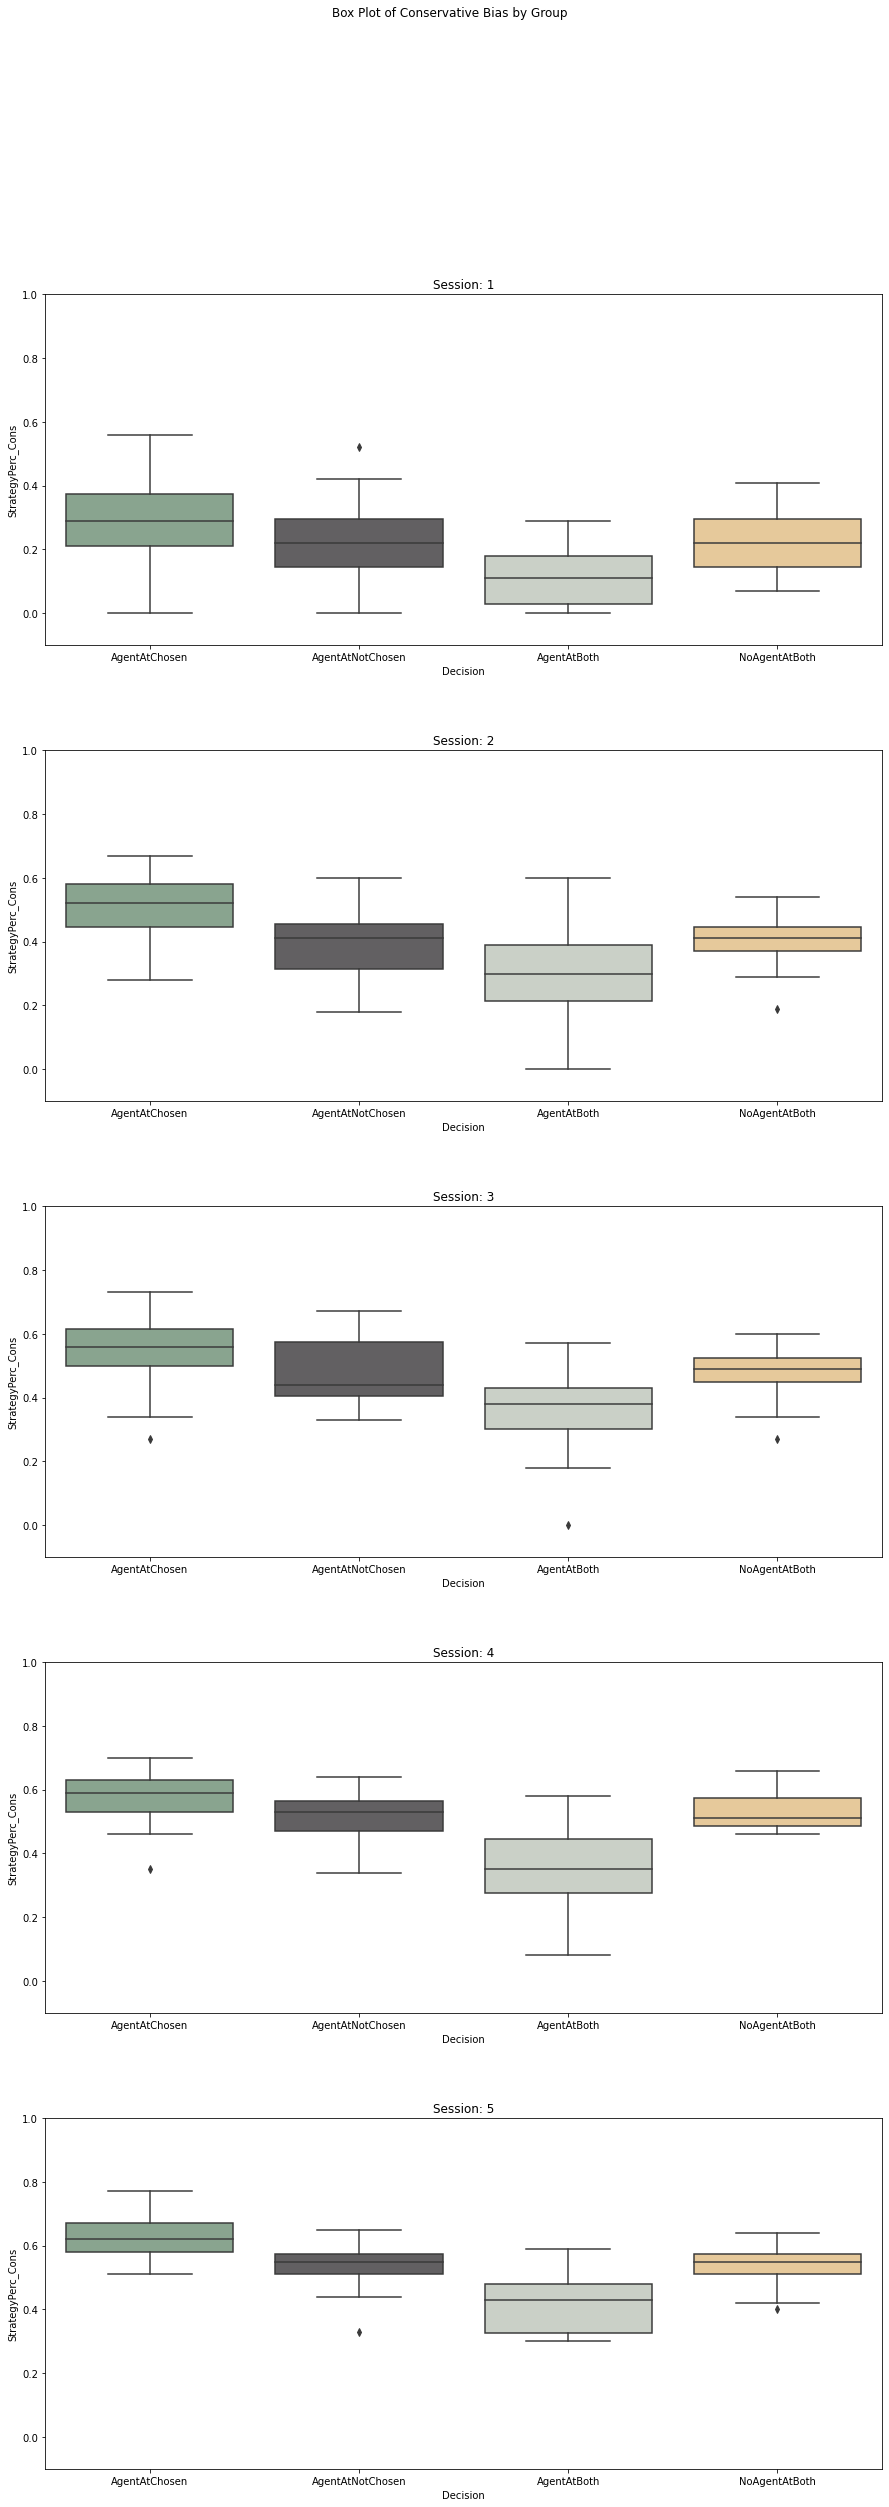

In [50]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15,40))
fig.suptitle('Box Plot of Conservative Bias by Group')
plt.subplots_adjust(hspace = 0.3)

### Customize the x-axis labels
#new_labels = ['Agent At Both','Act At Not Chosen', 'No Agent At Both',  
#              'Pas At Chosen', 'Pas Agent At Not Chosen', 'Act At Chosen']

session = 1
for row in range(5):

        sns.boxplot(data=df_Ratio_Dec[df_Ratio_Dec['Session'] == session], x='Decision', y='StrategyPerc_Cons',# order=sorted_df_red['Group'], 
                    ax=axes[row])

        # add subplot title
        if session < 6:
            axes[row].set_title(f'Session: {session}')
        
        # Rotate the x-axis labels by 90 degrees
        #legend_labels,_=axes[row].get_legend_handles_labels()
        #axes[row].set_xticklabels(new_labels)#, rotation=45)
        
        # Set the legend title and labels
        #legend = axes[row].legend(title="Experiment")
        
        # Set y-axis limits to [0, 1]
        axes[row].set_ylim(-0.1, 1)
        
        session += 1
        


plt.show()

In [51]:
df_agent_weighted = pd.DataFrame(columns=['ParticipantId', 'Session', 'StrategyCount', 'StrategyPerc' ,'Strategy', 
                                 'Decision','Conservative', 'Explorative', 'Total', 'Participant_Cat'])
decisions = ('AgentAtChosen', 'AgentAtNotChosen', 'AgentAtBoth', 'NoAgentAtBoth')

In [52]:
all_agentStrategyMatrices_weighted = []
for idx in range(len(inc_participants)):
    print('Participant: ' + str(inc_participants[idx]))
    agentStrategyMatrix_weighted = AgentStrategyMatrix(inc_participants[idx], cr, weight = 1)
    #strategyMatrix.createMatrix()
    sessions = agentStrategyMatrix_weighted.getSessions()
    for session in sessions:
        idx = 0
        for matrix in agentStrategyMatrix_weighted.matrix_total:
            cons_strat, expl_strat, tot_strat = Matrix.getStrategyCounts(matrix[session-1])
            if tot_strat != 0:
                perc_cons = round((cons_strat/tot_strat), 2)
                perc_expl = round((expl_strat/tot_strat),2)
            else:
                perc_cons = 0 
                perc_expl = 0

            df_agent_weighted = df_agent_weighted.append({'ParticipantId' : inc_participants[idx], 'Session' : session, 'StrategyCount' : cons_strat,
                            'StrategyPerc' : perc_cons, 'Strategy': 'Conservative', 'Decision' : decisions[idx], 
                            'Total' : tot_strat,'Participant_Cat' : 'Included'}, ignore_index = True)
            df_agent_weighted = df_agent_weighted.append({'ParticipantId' : inc_participants[idx], 'Session' : session, 'StrategyCount' : expl_strat, 
                            'StrategyPerc' : perc_expl,'Strategy': 'Explorative', 'Decision' : decisions[idx],
                            'Total' : tot_strat, 'Participant_Cat' : 'Included'}, ignore_index = True)
            idx += 1
    all_agentStrategyMatrices_weighted.append(agentStrategyMatrix_weighted)

Participant: 1754
Participant: 2258
Participant: 2693
Participant: 3310
Participant: 4176
Participant: 4796
Participant: 4917
Participant: 5238
Participant: 5741
Participant: 6642
Participant: 7093
Participant: 7412
Participant: 7842
Participant: 8007
Participant: 8469
Participant: 8673
Participant: 8695
Participant: 9472
Participant: 9502
Participant: 9601
Participant: 365
Participant: 4597
Participant: 9586


In [53]:
df_agent_weighted

,ParticipantId,Session,StrategyCount,StrategyPerc,Strategy,Decision,Conservative,Explorative,Total,Participant_Cat
0,1754,1,4.0,0.07,Conservative,AgentAtChosen,NaN,NaN,55.0,Included
1,1754,1,51.0,0.93,Explorative,AgentAtChosen,NaN,NaN,55.0,Included
2,2258,1,21.0,0.95,Conservative,AgentAtNotChosen,NaN,NaN,22.0,Included
3,2258,1,1.0,0.05,Explorative,AgentAtNotChosen,NaN,NaN,22.0,Included
4,2693,1,2.0,0.12,Conservative,AgentAtBoth,NaN,NaN,17.0,Included
...,...,...,...,...,...,...,...,...,...,...
915,2258,5,12.0,0.50,Explorative,AgentAtNotChosen,NaN,NaN,24.0,Included
916,2693,5,7.0,0.44,Conservative,AgentAtBoth,NaN,NaN,16.0,Included
917,2693,5,9.0,0.56,Explorative,AgentAtBoth,NaN,NaN,16.0,Included
918,3310,5,31.0,0.44,Conservative,NoAgentAtBoth,NaN,NaN,70.0,Included


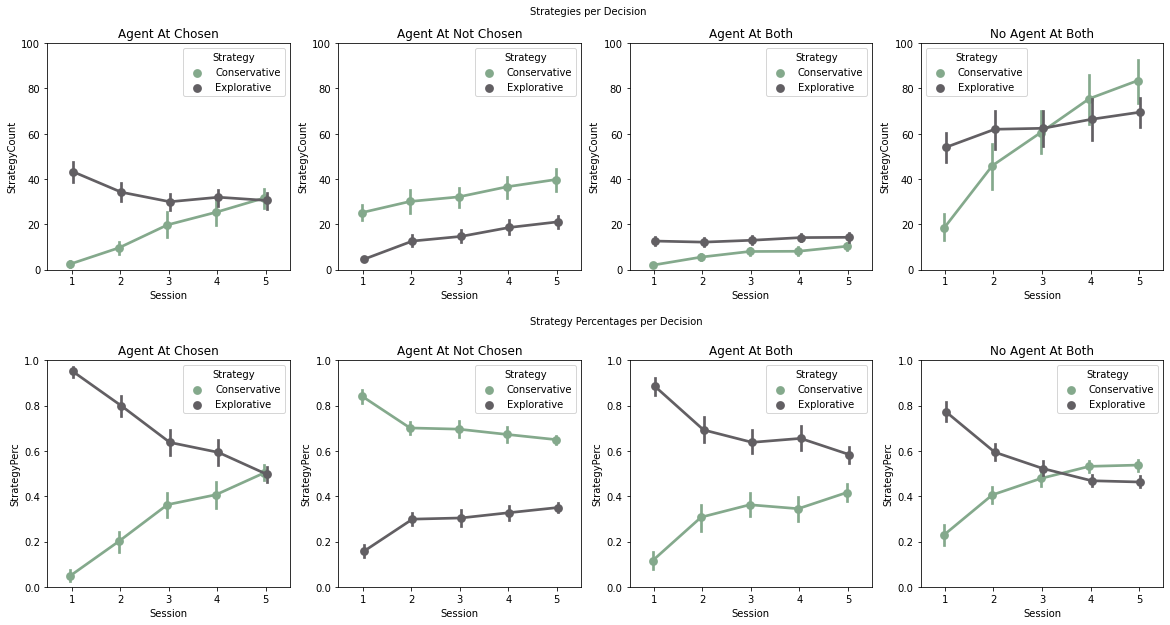

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
plt.subplots_adjust(hspace = 0.4)
#fig.suptitle('Strategies per Decision')
fig.text(x=0.46, y=0.92, s="Strategies per Decision")
fig.text(x=0.46, y=0.49, s="Strategy Percentages per Decision")
sns.set_palette(palette=color_palette)
subtitle_text = ('Agent At Chosen', 'Agent At Not Chosen', 'Agent At Both', 'No Agent At Both')

#fig.suptitle('Included')
for row in range(2):
    for col in range(4):
        if row == 0:
            sns.pointplot(x='Session', y='StrategyCount', dodge=True, hue='Strategy',
                  data=df_agent_weighted[df_agent_weighted['Decision'] == decisions[col]],ax=axes[row][col]).set_title(subtitle_text[col])
            axes[row][col].set_ylim(0, 100)
        else:
            sns.pointplot(x='Session', y='StrategyPerc', dodge=True, hue='Strategy',
                  data=df_agent_weighted[df_agent_weighted['Decision'] == decisions[col]],ax=axes[row][col]).set_title(subtitle_text[col])
            axes[row][col].set_ylim(0, 1)

In [55]:
df_Ratio_Dec_Weighted = pd.DataFrame()

#for idx in range(len(inc_participants)):
for agentStrategyMatrix in all_agentStrategyMatrices_weighted:
    participant = agentStrategyMatrix.participantId
    #print('Participant: ' + str(inc_participants[idx]))
    #agentStrategyMatrix = AgentStrategyMatrix(inc_participants[idx], cr)
    sessions = agentStrategyMatrix.getSessions()
    for session in sessions:
        idx = 0
        for matrix in agentStrategyMatrix.matrix_total:
            cons_strat, expl_strat, tot_strat = Matrix.getStrategyCounts(matrix[session-1])
            if tot_strat != 0:
                perc_cons = round((cons_strat/tot_strat), 2)
                perc_expl = round((expl_strat/tot_strat),2)
            else:
                perc_cons = 0 
                perc_expl = 0

            df_Ratio_Dec_Weighted = df_Ratio_Dec_Weighted.append({'ParticipantId' : participant, 'Session' : session, 'StrategyCons' : cons_strat,
                             'StrategyExpl' : expl_strat,'StrategyPerc_Cons' : perc_cons,'StrategyPerc_Expl' : perc_expl, 'Decision' : decisions[idx], 
                            'Total' : tot_strat,'Participant_Cat' : 'Included'}, ignore_index = True)
            idx += 1


In [56]:
df_Ratio_Dec_Weighted['Ratio'] = df_Ratio_Dec_Weighted['StrategyExpl'] / df_Ratio_Dec_Weighted['StrategyCons']

In [57]:
df_Ratio_Dec_Weighted['Ratio'] = df_Ratio_Dec_Weighted['Ratio'].replace(np.inf, 0)

In [58]:
df_Ratio_Dec_Weighted

,ParticipantId,Session,StrategyCons,StrategyExpl,StrategyPerc_Cons,StrategyPerc_Expl,Decision,Total,Participant_Cat,Ratio
0,1754.0,1.0,4.0,51.0,0.07,0.93,AgentAtChosen,55.0,Included,12.750000
1,1754.0,1.0,21.0,1.0,0.95,0.05,AgentAtNotChosen,22.0,Included,0.047619
2,1754.0,1.0,2.0,15.0,0.12,0.88,AgentAtBoth,17.0,Included,7.500000
3,1754.0,1.0,22.0,52.0,0.30,0.70,NoAgentAtBoth,74.0,Included,2.363636
4,1754.0,2.0,8.0,42.0,0.16,0.84,AgentAtChosen,50.0,Included,5.250000
...,...,...,...,...,...,...,...,...,...,...
455,9586.0,4.0,38.0,42.0,0.48,0.52,NoAgentAtBoth,80.0,Included,1.105263
456,9586.0,5.0,15.0,19.0,0.44,0.56,AgentAtChosen,34.0,Included,1.266667
457,9586.0,5.0,12.0,12.0,0.50,0.50,AgentAtNotChosen,24.0,Included,1.000000
458,9586.0,5.0,7.0,9.0,0.44,0.56,AgentAtBoth,16.0,Included,1.285714


In [59]:
df_Ratio_Dec_Weighted[df_Ratio_Dec_Weighted['ParticipantId'] == 1754]

,ParticipantId,Session,StrategyCons,StrategyExpl,StrategyPerc_Cons,StrategyPerc_Expl,Decision,Total,Participant_Cat,Ratio
0,1754.0,1.0,4.0,51.0,0.07,0.93,AgentAtChosen,55.0,Included,12.750000
1,1754.0,1.0,21.0,1.0,0.95,0.05,AgentAtNotChosen,22.0,Included,0.047619
2,1754.0,1.0,2.0,15.0,0.12,0.88,AgentAtBoth,17.0,Included,7.500000
3,1754.0,1.0,22.0,52.0,0.30,0.70,NoAgentAtBoth,74.0,Included,2.363636
4,1754.0,2.0,8.0,42.0,0.16,0.84,AgentAtChosen,50.0,Included,5.250000
5,1754.0,2.0,30.0,16.0,0.65,0.35,AgentAtNotChosen,46.0,Included,0.533333
6,1754.0,2.0,9.0,9.0,0.50,0.50,AgentAtBoth,18.0,Included,1.000000
7,1754.0,2.0,32.0,68.0,0.32,0.68,NoAgentAtBoth,100.0,Included,2.125000
8,1754.0,3.0,24.0,36.0,0.40,0.60,AgentAtChosen,60.0,Included,1.500000
9,1754.0,3.0,41.0,26.0,0.61,0.39,AgentAtNotChosen,67.0,Included,0.634146


In [60]:
df_Ratio_Dec[df_Ratio_Dec['ParticipantId'] == 1754]

,ParticipantId,Session,StrategyCons,StrategyExpl,StrategyPerc_Cons,StrategyPerc_Expl,Decision,Total,Participant_Cat,Ratio
0,1754.0,1.0,7.0,25.0,0.22,0.78,AgentAtChosen,32.0,Included,3.571429
1,1754.0,1.0,6.0,19.0,0.24,0.76,AgentAtNotChosen,25.0,Included,3.166667
2,1754.0,1.0,2.0,15.0,0.12,0.88,AgentAtBoth,17.0,Included,7.500000
3,1754.0,1.0,22.0,52.0,0.30,0.70,NoAgentAtBoth,74.0,Included,2.363636
4,1754.0,2.0,22.0,27.0,0.45,0.55,AgentAtChosen,49.0,Included,1.227273
5,1754.0,2.0,13.0,27.0,0.32,0.68,AgentAtNotChosen,40.0,Included,2.076923
6,1754.0,2.0,9.0,9.0,0.50,0.50,AgentAtBoth,18.0,Included,1.000000
7,1754.0,2.0,32.0,68.0,0.32,0.68,NoAgentAtBoth,100.0,Included,2.125000
8,1754.0,3.0,36.0,25.0,0.59,0.41,AgentAtChosen,61.0,Included,0.694444
9,1754.0,3.0,26.0,40.0,0.39,0.61,AgentAtNotChosen,66.0,Included,1.538462


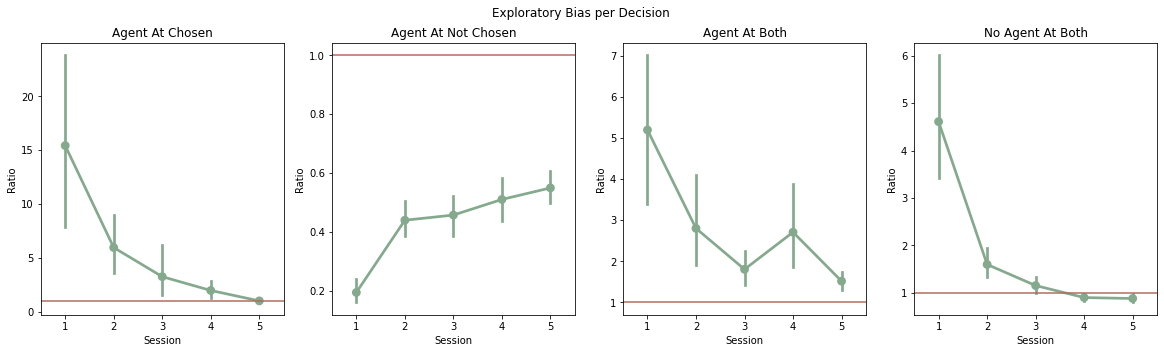

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))    
plt.subplots_adjust(hspace = 0.4)
fig.suptitle('Exploratory Bias per Decision')
sns.set_palette(palette=color_palette)
subtitle_text = ('Agent At Chosen', 'Agent At Not Chosen', 'Agent At Both', 'No Agent At Both')

for col in range(4):
    sns.pointplot(x='Session', y='Ratio', dodge=True,
          data=df_Ratio_Dec_Weighted[df_Ratio_Dec_Weighted['Decision'] == decisions[col]],ax=axes[col], order = [1,2,3,4,5]).set_title(subtitle_text[col])
    axes[col].axhline(1.0, color = '#b36a5e')
    #axes[col].set_ylim(0, 7)